# Executive Summary

* The dataset that will be processed is "Flight Data Recorcder" data containing 300 csv files, where each file consist of nearly 200 variables, when an aircraft depart from certain airport and landing to specific airport which is *Memphis International Airport (MEM), TN, USA*. The aircraft is also limited to 4 engines aircraft (Boeing 747).
<br>

* Explanation of each variables can be found on flight_data_parameter.csv'
<br>

*  This notebook shows the steps done to clean, Exploratory Data Analysis (EDA) process, and creating dataset, with the goal is to develop auto landing deep learning model using TensorFlow, focusing on elevator and power lever angle model
<br>

*  The result is train_set, val_set, and clean_set, that later on will be used on developing ML model phase. 
<br>

###### The cleaning process done including: 

* Rename csv files
* Resample frequency of each file
* Remove NaN values
* Slice each file, focusing only on landing phase
* Remove unnecessary column
* Delete outliers using IQR method
* Delete data that having different distribution
* Calibrate variables

## Import Library

In [2]:
import os
import pandas as pd
import numpy as np
import glob
import shutil
import random
import matplotlib.pyplot as plt

##### Since the csv file name is too long, the rename_files function below created

In [2]:
def rename_files(folder_dir, csv_name):
    '''Rename all csv files inisde a folder '''
    
    # Creating list consisting all file name in a folder
    all_files_name = os.listdir(folder_dir)
    
    # Loop over all files in folder
    for i in range(len(all_files_name)):

        # Initate old path and new path variable
        old_full_path = os.path.join(folder_dir, all_files_name[i])
        new_full_path = os.path.join(folder_dir, (csv_name + '_{}.csv'.format(i)))

        # Using rename function to convert old path to new path
        os.rename(old_full_path, new_full_path)

##### It founded that the data frequency is 8Hz. So it will be converted becoming 1 data points every 2 seconds.
##### Hence, the resample_df function below is created.

In [3]:
def resample_df(df):
    '''Resample data freq from 8Hz
    becoming 1 data points every 2 seconds'''
    
    # Create new column as DateTimeIndex type
    df['Date_time'] = pd.DatetimeIndex(df['time_s']*1e10)
    # Assign the 'Date_time' column as index
    df = df.set_index('Date_time')
    # Using resample function with first method ('20S' will convert from 8Hz to 0.5Hz)
    df = df.resample('20S').first()
    # Convert the index back to the 'time_s' column
    df = df.set_index('time_s')
    
    return df    

##### As we focused on developing auto landing model. We will focusing on the section of data where the altitude is below or greater than 10,000 feets or 3,000 meters [1]. Hence after resample the data, we will cut the data starting from 3,000 meters altitude. 

##### Also, since we only focus on the phase where aircraft is airborne. Hence, when the aircraft is already touching the runway or we can see from weight on wheel variables changing from 1 to 0, we will set that index as the end of our data. 

##### After that, we want to cut data points where aircraft still have rolling manuever in order to allign with the runway. It will be done by defining the runway boundary. Since all of the data consisting of flights data land in the same airport, one boundary is enough for all files

###### [1] https://www.skytough.com/post/when-do-planes-start-descending

In [4]:
def approach_phase(df):
    '''Cut the data starting at 3,000 meters and end when WOW variable change become 0,
    then find the approach phase where ac allign with the runway'''
    
    # Slice df from half of df until the end
    df = df[int(0.5*len(df)):]
    # filter df where altitude is less than equal to 3000 m 
    df = df.loc[df['hbaro_m']<=3000]
    # filter df where weight on wheel is 1 (remove ground phase)
    df_cut = df.loc[df['wow']==1]
    
    # Approach phase
    rw_lon = df_cut['lon_rad'].iloc[-1]
    rw_lat = df_cut['lat_rad'].iloc[-1]

    index_cut = []
    delta = 0.0002
    rw_low = rw_lon + delta
    rw_up = rw_lon - delta

    # Find the index where aircraft start to enter alligning lon lat to the runway. 
    for index, (lon, lat) in enumerate(zip(df_cut['lon_rad'], df_cut['lat_rad'])):
        if (lon>=rw_up and lon<=rw_low) and (lat<rw_lat):
            index_cut.append(index)
            break
    if len(index_cut)!=0:
        return df_cut.iloc[index_cut[0]:]
    else:
        return df_cut

##### We found that after resampled process, this variables still have NaN values and it will not needed

['db_id_1', 'db_id_2', 'engcycle_1_hr', 'engcycle_2_hr', 'engcycle_3_hr',
'engcycle_4_hr', 'eng_1_hr', 'eng_2_hr', 'eng_3_hr', 'eng_4_hr',
'eng_1_sn', 'eng_2_sn', 'eng_3_sn', 'eng_4_sn', 'frame_counter']

##### By filtering unnecessary column, by using parameter definition of each variable files, by seeing the unit that have big possibility it will not necessary for creating auto landing model, Those units are: 

* PSI, Day, Month, Year, Hours, LBS/HR, LBS, Hour, Minute, and Second. 

##### And those variables are: 

["brkpress_lgre_npm2", "brkpress_rgre_npm2", "brkpress_lyel_npm2", "brkpress_ryel_npm2",
 "day", "month", "year", "engcycle_1_hr", "engcycle_2_hr", "engcycle_3_hr", "engcycle_4_hr",
 "eng_1_hr", "eng_2_hr", "eng_3_hr", "eng_4_hr", "ff_1_kgps", "ff_2_kgps", "ff_3_kgps", "ff_4_kgps",
 "fqty_1_kg", "fqty_2_kg", "fqty_3_kg", "fqty_4_kg", "gmt_hr", "gmt_min", "gmt_s", "oilpress_1_npm2",
  "oilpress_2_npm2", "oilpress_3_npm2", "oilpress_4_npm2"]
  
#### Hence, to remove those column name, the clean_df function below is created. 

In [5]:
def clean_df(df):
    '''Clean the remaining dataframe from NaN values'''
    
    # Find the index variable that still contain NaN, and store it to a list
    var_list = []

    for ind,value in enumerate(df.isnull().sum()):
        if value != 0:
            var_list.append(ind)

    # Find what variable is it
    col_list = df.columns

    # Drop column that contains NaN values
    df = df.drop(columns=col_list[var_list])
    
    # Drop unnecessary column
    # Define those column name to be dropped
    column_name_drop = ["brkpress_lgre_npm2", "brkpress_rgre_npm2", "brkpress_lyel_npm2", "brkpress_ryel_npm2",
                    "day", "month", "year", "engcycle_1_hr", "engcycle_2_hr", "engcycle_3_hr", "engcycle_4_hr",
                    "eng_1_hr", "eng_2_hr", "eng_3_hr", "eng_4_hr", "ff_1_kgps", "ff_2_kgps", "ff_3_kgps", "ff_4_kgps",
                    "fqty_1_kg", "fqty_2_kg", "fqty_3_kg", "fqty_4_kg", "gmt_hr", "gmt_min", "gmt_s", "oilpress_1_npm2",
                    "oilpress_2_npm2", "oilpress_3_npm2", "oilpress_4_npm2"]
    
    # Loop over the list, and drop the column if their name is similar.
    for col_name in column_name_drop:
        if col_name in df:
            df = df.drop(columns = col_name)
    
    return df

##### This function below is created to pass all cleaning function that have been created, resulting to cleaned csv files on another folder

In [6]:
def create_clean_csv(ori_path, clean_path):
    '''Pass resample_df and clean_df function
    to clean original csv files and put it in clean path folder '''
    
    counter = 0
    all_files_name = os.listdir(ori_path)
    
    for i in range(len(all_files_name)):
        ori_file_path = os.path.join(ori_path, all_files_name[i])
        clean_file_path = os.path.join(clean_path, all_files_name[i])
        
        df = pd.read_csv(ori_file_path)
        df = df.round(4)
        df = resample_df(df)
        df = approach_phase(df)
        df = clean_df(df)
        
        # Since the 'hbaro_m' variable for approach phase usually below 1000m,
        # and the size of the csv below 1000. When this criteria met, the data will be removed
        if df['hbaro_m'].iloc[1]>=1200 or len(df)>=1000:
            print('{} removed'.format(all_files_name[i]))
            counter +=1
            pass
        else:
            df.to_csv(clean_file_path)
    
    print('{} has been removed'.format(counter))
    print('Cleaning process has been completed!')

## Cleaning CSV Process

In [9]:
# Filter data only when the aircraft already allign with the runway and remove data that
# isnt in the criteria using function that have been made before

ori_path = 'D:\Downloads\FDR Landing - Excel\Full Flights'
dest_path = 'D:\Downloads\FDR Landing - Excel\Landing_Cleaned'

create_clean_csv(ori_path, dest_path)

Flight_112.csv removed
Flight_114.csv removed
Flight_168.csv removed
Flight_201.csv removed
Flight_208.csv removed
Flight_21.csv removed
Flight_211.csv removed
Flight_240.csv removed
Flight_242.csv removed
Flight_246.csv removed
Flight_260.csv removed
Flight_284.csv removed
Flight_36.csv removed
Flight_51.csv removed
Flight_90.csv removed
15 has been removed
Cleaning process has been completed!


* **From this process, it founded that 15 files has not met the criteria for runway boundary and be removed**

## Deeper Cleaning

### Exploratory Data Analysis (EDA)
#### Find relation between control column position vs elevator deflection

In [13]:
# List all processed file from landing dirty folder, and get 5 random sample of it to be plotted

all_path = [i for i in glob.glob('D:\Downloads\FDR Landing - Excel\Landing_Cleaned\*.csv')]

random.shuffle(all_path)

sample_path = all_path[:5]

Plot below is for Flight_91.csv


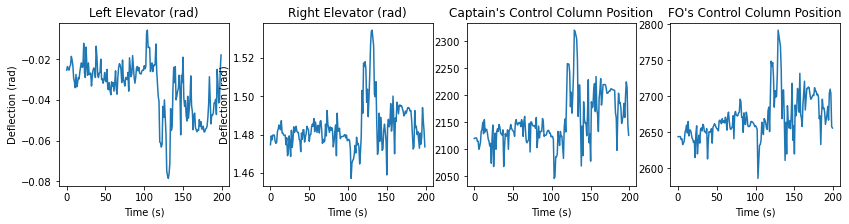

Plot below is for Flight_172.csv


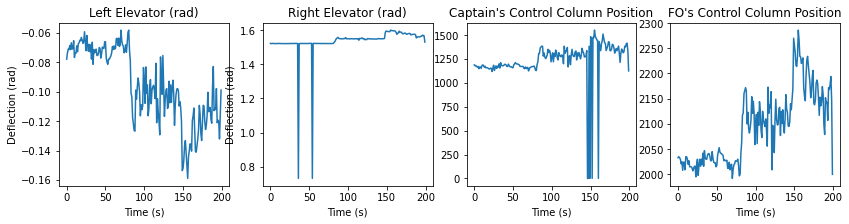

Plot below is for Flight_243.csv


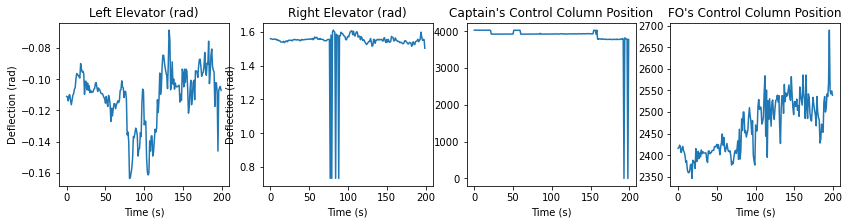

Plot below is for Flight_49.csv


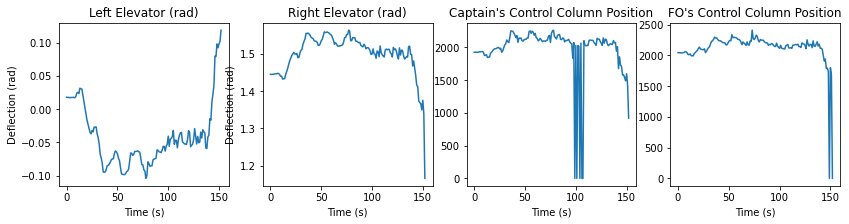

Plot below is for Landing_189.csv


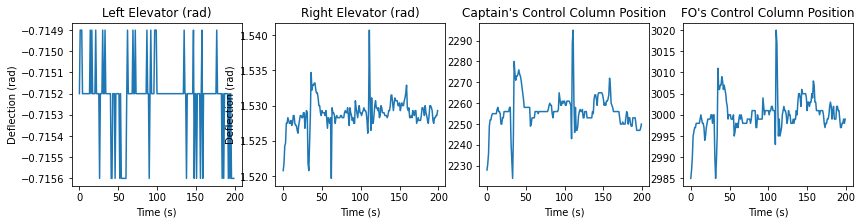

In [22]:
 for path in sample_path:
        df = pd.read_csv(path)
        file_name = os.path.split(path)[-1]
        
        print('Plot below is for {}'.format(file_name))
        # Plotting
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14,3))

        ax[0].plot(df['elv_l_rad'][:200])
        ax[0].set_title('Left Elevator (rad)')
        ax[0].set_xlabel('Time (s)')
        ax[0].set_ylabel('Deflection (rad)')

        ax[1].plot(df['elv_r_rad'][:200])
        ax[1].set_title('Right Elevator (rad)')
        ax[1].set_xlabel('Time (s)')
        ax[1].set_ylabel('Deflection (rad)')

        ax[2].plot(df['ctrlcolumn_pos_capt'][:200])
        ax[2].set_title("Captain's Control Column Position")
        ax[2].set_xlabel('Time (s)')

        ax[3].plot(df['ctrlcolumn_pos_fo'][:200])
        ax[3].set_title("FO's Control Column Position")
        ax[3].set_xlabel('Time (s)')
        
        plt.show()
        

* In real case, we know that if pilot push the control column, the aircraft will pitch down, because elevator will deflect downward creating moment that make aircraft nose face downward. 

* From graph observation, we found an hypothesis which is if control column position value is increasing, it means that pilot give push command, that leads to more negative deflection of elevator. 

* Hence, by seeing graph above, the variable that create more sense is elevator left rather than elevator right. We also know that elevator deflection direction should be the same.  So we need to pick one of those and elevator_left will be picked as the target

##### From graph above, we also see the data has outliers in it. To remove outliers, we will use IQR method.

#####  It can be seen from graph above, espescially on sample named 'Landing_189.csv'. The left elevator variable graph shown fluctuative and impossible value, that maybe because of  sensor misreading.  

##### Strategy that we will implement is to inspect manualy, what file give 'jumpy' elevator graph, and then list the name of that file to be removed

In [ ]:
# Inspect visually the elv_l_rad variable where the sensor posibbly broken
csv_files = os.listdir('D:\Downloads\FDR Landing - Excel\Landing_Cleaned')

for file in csv_files:
    df = pd.read_csv(os.path.join('D:\Downloads\FDR Landing - Excel\Landing_Cleaned', file))
    
    print('plot below is for {}'.format(file))
    plt.plot(df['elv_l_rad'])
    plt.show()

In [11]:
unwanted_list = ['155', '158', '159', '160', '164', '165',
                '169', '173', '174', '176', '181', '183',
                 '187','188', '191', '192', '193', '194',
                 '195','196', '197', '198', '199', '202',
                 '203','204', '205', '206', '207', '209',
                 '213','214', '216', '218', '219']

* There are 35 files that will be removed

In [12]:
# Loop over the unwanted_list and remove that files

for name in unwanted_list:
    full_name = 'Flight_' + name +'.csv'
    full_path = os.path.join('D:\Downloads\FDR Landing - Excel\Landing_Cleaned',full_name)
    if os.path.isfile(full_path):
        os.remove(full_path)

### Get Initial Condition for Each File

* Goal of this process is to know the initial value of each variables, as zero point to calibrate the variables. Espescially the elv_l_rad variable.

* Data where elv_l_rad variable at initial position is different with the others will be deleted, using IQR method

In [21]:
# Process to create initial condition dataframe

df_name = pd.read_csv('D:\Downloads\FDR Landing - Excel\Landing_Cleaned\Flight_0.csv')
all_file_name = os.listdir('D:\Downloads\FDR Landing - Excel\Landing_Cleaned')

# Initialize blank dataframe with same column name as df_name or existing data
collect_df = pd.DataFrame(columns = df_name.columns)

for i in range(len(all_file_name)):
    # It will read the original file with specific name on landing cleaned folder 
    df = pd.read_csv(os.path.join('D:\Downloads\FDR Landing - Excel\Full Flights', all_file_name[i]))
    collect_df.loc[i,:] = (df.loc[0,:]) #Get first data point of each file and append it to collect_df

# We will save this initial condition dataframe.
save_path = 'D:\Downloads\FDR Landing - Excel\intial_condition_with_noise.csv'
# collect_df.to_csv(save_path)
collect_df = pd.read_csv(save_path)

##### We plot all initial condition for elv_l_rad to see outliers and baseline of this variable

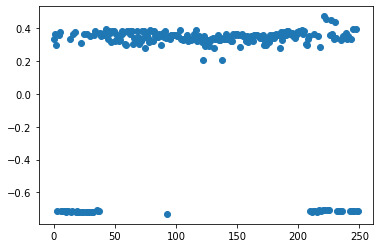

In [61]:
plt.scatter([i for i in range(len(collect_df))],collect_df['elv_l_rad'])

* It can be seen that several data points have value near -0.7, meanwhile the rest of the data have intial condition for left elevator is at 0.3

* Hence, we will remove those outlier files using IQR method

In [14]:
# Find index where there is outliers in elv_l_rad variable
Q1,Q3 = np.percentile(collect_df['elv_l_rad'], [25,75])
IQR = Q3-Q1
low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR

# Drop dataframe that exceed or below the limit. 
index_outliers = (collect_df[(collect_df['elv_l_rad']<low_lim) | (collect_df['elv_l_rad']>up_lim)].index)

In [15]:
len(index_outliers)

50

* From the IQR method, we found 50 files that will be removed

In [17]:
# Remove the file that have outliers based on the index in all_file_name variable

all_file_name = os.listdir('D:\Downloads\FDR Landing - Excel\Landing_Cleaned')

for index in index_outliers:
    full_path = os.path.join('D:\Downloads\FDR Landing - Excel\Landing_Cleaned', all_file_name[index])
    os.remove(full_path)

##### Then, we plot the clean dataframe without outliers value to see wether the outliers have beeen removed or not

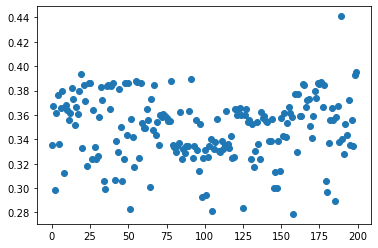

In [18]:
collect_clean = collect_df.drop(collect_df[(collect_df['elv_l_rad']<low_lim) | (collect_df['elv_l_rad']>up_lim)].index)

# Scatter plot the elv_l_rad variable, and it founded the outliers have been removed
plt.scatter([i for i in range(len(collect_clean))],collect_clean['elv_l_rad'])

* We can see that outliers already removed and the distribution of elv_l_rad data is more concentrated arround 0.3

##### We find the average of initial condition over 200 files left, and convert it do degree to overcome sensitiveness in rounding at radian unit

In [19]:
print('Average initial condition for elv_l_rad is {} deg'.format(np.rad2deg(collect_clean['elv_l_rad'].mean())))

Average initial condition for elv_l_rad is 20.00826687964884 deg


##### It founded that average initial condition of elevator position is about 20 degrees. 

##### So, we will calibrate it by subtract all the value with this average intial condition value, and also applying 'IQR_col' function to remove outliers

In [7]:
def IQR_col(df, col_name):  
    '''Clean data using IQR method based on col_name defined'''
    Q1,Q3 = np.percentile(df[col_name], [25,75])
    IQR = Q3-Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR

    # Drop dataframe that exceed or below the limit. 
    df_new = df.drop(df[(df[col_name]<low_lim) | (df[col_name]>up_lim)].index)
    
    return df_new

In [22]:
all_path = [i for i in glob.glob('D:\Downloads\FDR Landing - Excel\Landing_Cleaned\*.csv')]

for path in all_path:
    df = pd.read_csv(path)
    df = IQR_col(df, 'elv_l_rad')
    df['elv_l_rad'] = np.rad2deg(df['elv_l_rad']) - 20.008 # Change to degree and calibrate the value
    df = df.rename({'elv_l_rad': 'elv_l_deg'}, axis=1) # Change the dataframe column name
    df.to_csv(path)

##### After that, we can rename all the files inside 'Landing_Cleaned' folder 

In [20]:
folder_dir = 'D:\Downloads\FDR Landing - Excel\Landing_Cleaned'
csv_name = 'Landing'

rename_files(folder_dir, csv_name)

##### The next step is to concatenate all csv files that have been cleaned.

##### It founded that after concatenate all of the csv files, this column name have mean value equal to zero and it wont be necessary for building the auto landing model. Hence this column will be dropped.

['apu_fire_warning', 'brkpress_lgre_npm2', 'hcabin_high', 'eng_1_fire',
'eng_2_fire', 'eng_3_fire', 'eng_4_fire', 'fqty_2_kg', 'fqty_3_kg',
'master_warn', 'povt', 'smoke_warning', 'tail_antiice', 'tcas',
'to_conf_warn', 'inner_wing_deice', 'outer_wing_antiice']
       
##### In 'concat_csv' function below, we also pass the IQR_col function to remove outliers espescially for elevator left variable, since that variable is our target. 

In [8]:
def concat_csv(path_criteria, dest_path):
    '''Path criteria is path with character of the extension file'''
    
    file_list = glob.glob(path_criteria)
    df = pd.concat(map(pd.read_csv, file_list), ignore_index = True)
    
    # Find column with mean = 0 in concatenate dataframe and drop that column 
    df = df.loc[:, (df.mean(axis=0) != 0)]
    
    # Drop outliers in overall dataset
    df = IQR_col(df, 'elv_l_deg')
    
    # Assign concatenated df as csv files in dest_path
    df.to_csv(dest_path)

##### Concatenating  200 csv files become 1 dataset

In [9]:
path_criteria = 'D:\Downloads\FDR Landing - Excel\Landing_Cleaned\*.csv'
dest_path = 'D:\Downloads\FDR Landing - Excel\Landing_dataset.csv'

concat_csv(path_criteria, dest_path)

##### After we create the dataset, we want to see the correlation of specific variable especially the target. 

##### By using the function created below, we can see the correlation between elevator variable with another variables (in %)

In [1]:
def df_corr(df,var):
    """clean up NaN values after using correlation function, convert it into percentage,
    convert it as dataframe both for positive and negative value,
    and sort descending for the absolute value.
    (df is dataframe that want to be analyzed, and var is name of parameter which we want to correlate)"""
    
    
    # Positive values section
    
    # Calculating pos_correlation of all dataframe in percent
    corr = np.round(df.corr()*100,2)
    
    # Sort pos_correlation value descending
    corr = corr.sort_values(by=[var], ascending=False)[var]
    corr = corr.to_frame() # Convert series to DataFrame
    corr = corr.dropna() # Drop NaN values of the DataFrame

    # Create new column for positive pos_correlation value
    pos_corr = corr[[var]].copy() # Create a copy of correlation dataframe
    pos_corr['pos_cor_'+ var] = pos_corr[var].where(pos_corr[var]>0)

    # Drop original column
    pos_corr.drop(var,axis=1,inplace=True)

    # Drop NaN value as a result of filtering positive value only
    pos_corr = pos_corr.dropna(subset=['pos_cor_'+ var])
    
# -----------------------------------------------------------------------
    # Negative values section
    
    # Create new column for negative correlation value
    neg_corr = corr[[var]].copy() # Create a copy of correlation dataframe
    neg_corr['neg_corr_'+ var] = neg_corr[var].where(neg_corr[var]<0)

    # Drop original column
    neg_corr.drop(var,axis=1,inplace=True)

    # Drop NaN value as a result of filtering positive value only
    neg_corr = neg_corr.dropna(subset=['neg_corr_'+ var])
    neg_corr = neg_corr.sort_values(by=['neg_corr_'+ var],axis=0, ascending=True)

    return pos_corr, neg_corr

#### Show top 10 positive and negative correlation

In [10]:
df = pd.read_csv('D:\Downloads\FDR Landing - Excel\Landing_dataset.csv')
pos_corr, neg_corr = df_corr(df, 'elv_l_deg')

In [11]:
pos_corr[:10]

,pos_cor_elv_l_deg
elv_l_deg,100.00
aoai_rad,56.37
aoac_rad,56.36
aoa_1_rad,56.08
aoa_2_rad,55.29
theta_rad,45.21
ax_body_mps2,45.08
gear_lr_dwnlck,21.49
airspd_selected_mps,20.93
mach_selected,20.68


In [12]:
neg_corr[:10]

,neg_corr_elv_l_deg
elv_r_rad,-43.19
flap_te_pos,-32.28
gear_lr_uplck,-24.68
lg_squat_ml,-23.81
lg_squat_mr,-23.79
ctrlcolumn_pos_capt,-23.14
engvbr_4_inps,-21.85
lat_rad,-16.10
gs_dev_ddm,-14.79
engvbr_1_inps,-14.01


##### From this correlation value, some variable will be picked as features in elevator and throttle controller model. 
##### It picked based on pyshic phenomenon that essentialy related with each target variable. 

##### Hence, the features we pick as features for elevator model are: 

* **aoac_rad** (angle of attack corrected in radians)
* **theta_rad** (aircraft pitch angle in radians)
* **ax_body_mps2** (aircraft body acceleration)

##### While, the features we pick as features for throttle controler model are: 

* **gs_mps** (ground speed)
* **ax_body_mps2** (aircraft body acceleration)
* **hdot_1_mps** (altitude rate)
* **hralt_m** (radio altitude)

##### Next, we will plot boxplot for the possible features and targets to see distribution of each variable

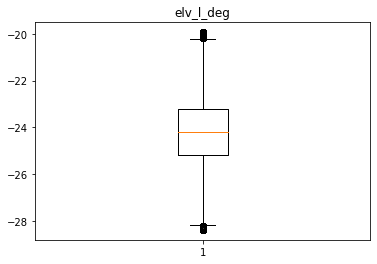

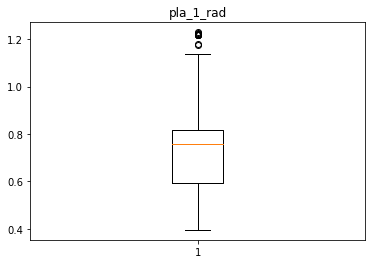

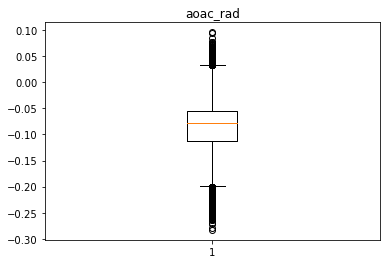

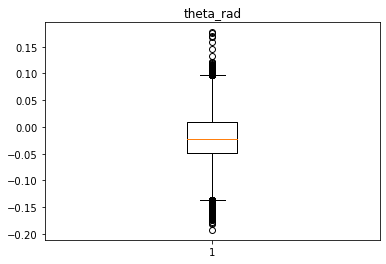

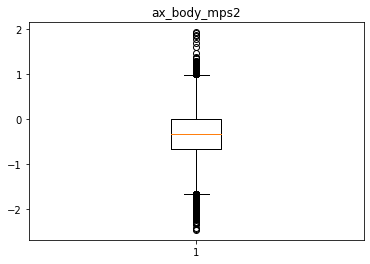

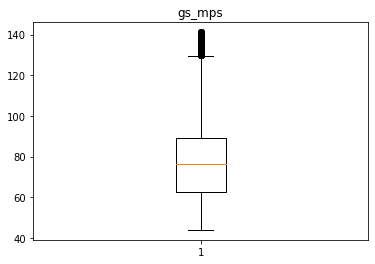

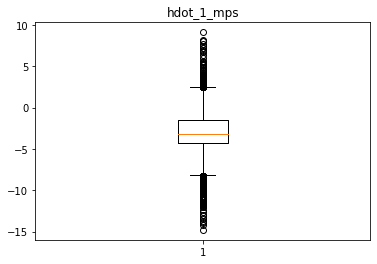

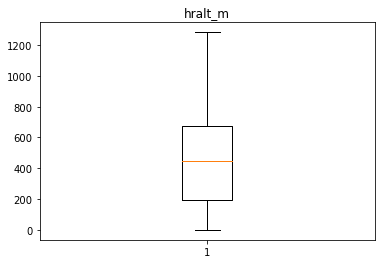

In [13]:
pos_feat_targ = ['elv_l_deg', 'pla_1_rad',
                 'aoac_rad', 'theta_rad', 'ax_body_mps2',
                 'gs_mps', 'hdot_1_mps', 'hralt_m']

for col_name in pos_feat_targ:
    plt.boxplot(df[col_name])
    plt.title(col_name)
    plt.show()

* We found that the distribution of features and targets is make sense and normal. So, we can move to the next step to split dataset

## Data Splitting

In [81]:
# First we will make a list consisting all files path in the folder, and shuffle it before slicing based on set size
all_file_name = [i for i in glob.glob('D:\Downloads\FDR Landing - Excel\Landing_Cleaned\*.csv')]
random.shuffle(all_file_name)

In [83]:
full_size = len(all_file_name)

# The proportion we use is 80% for training, 10% for validation, and the rest for test size
train_size = int(full_size*0.8)
val_size = train_size + int(full_size*0.1)

# Slice based on each defined set size, resulting variables consisting designated file path
train_set = all_file_name[:train_size]
val_set = all_file_name[train_size:val_size]
test_set = all_file_name[val_size:]

##### Based on train_set, val_set, test_set variables, we will concatenate file inside the variable to create dataset using function below

In [85]:
def concat_set(set_list, file_name):
    df = pd.concat(map(pd.read_csv, set_list), ignore_index = True)
    df = IQR_col(df, 'elv_l_deg')
    # Assign concatenated df as csv files in dest_path
    df.to_csv(os.path.join('D:\Downloads\FDR Landing - Excel', file_name))

##### Then, we will pass the variable and the file name we want, to create corresponding dataset

In [88]:
set_list = val_set
file_name = 'val_set.csv'

concat_set(set_list, file_name)

##### Next step is to create test set folder, because we want to compare our model result for each flight data 

In [84]:
for file_path in test_set:
    dest_path = os.path.join('D:\Downloads\FDR Landing - Excel\Test Set', file_path.split("\\")[-1])
    shutil.copy(file_path, dest_path) #Copy file inside the test_set variable to Test Set folders